In [1]:
import torch
import numpy as np
import scipy.sparse as sp
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn import model_selection
import torch.optim as optim
from torch.nn.utils.rnn import *
import matplotlib.pyplot as plt

## Generate normalized adjacency matrix and normalize the feature matrix

In [2]:
def normalized_adjacency(adj):
    adj = adj + sp.eye(adj.shape[0])
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt).tocoo()

def row_normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(x.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return x


## Preprocess input features

In [3]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def sgc_precompute(features, adj, degree):
    adj = normalized_adjacency(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj).float()
    features = torch.tensor(features)
    for i in range(degree):
        features = torch.spmm(adj, features)
    return features



In [4]:
class MyDataset(Dataset):
    def __init__(self, X, A, Y, degree):
        self.X = X
        self.A = A
        self.Y = Y
        self.degree = degree
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, index):
        X = sgc_precompute(self.X[index], self.A[index], self.degree)
        return X, torch.tensor(self.Y[index])
def collate_fn(batch_data):
    X_list = []
    Y_list = []
    for data in batch_data:
        X_list.append(data[0])
        Y_list.append(data[1])
    padded_X = pad_sequence(X_list, padding_value = 0, batch_first = True)
    return padded_X, torch.LongTensor(Y_list)

## Models

In [5]:
class SGC(nn.Module):
    """
    A Simple PyTorch Implementation of Logistic Regression.
    Assuming the features have been preprocessed with k-step graph propagation.
    """
    def __init__(self, nfeat, nclass):
        super(SGC, self).__init__()

        self.linear1 = nn.Linear(nfeat, 10)
        self.linear2 = nn.Linear(10, nclass)
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        output = self.linear2(x)
        return output

In [6]:
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, num_epoch):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epoch):
        model.train()
        correct = 0
        total = 0
        running_loss = 0
        for batch_idx, (X, Y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            
            output = model.forward(X)
            output = torch.sum(output, dim = 1, keepdim = False)
            pred = torch.argmax(output, dim = 1)
            
            """
            X = torch.sum(X, dim = 1, keepdim = False)
            print(X.shape)
            output = model.forward(X)
            pred = torch.argmax(output, dim = 1)
            print(output.shape)
            print(pred.shape)
            print(Y.shape)
            """
            
            correct += (pred==Y).sum().item()
            total += Y.size(0)
            train_acc = correct/total
            loss = criterion(output, Y) 
            running_loss += loss.item() * Y.size(0)
            train_loss = running_loss/total
            loss.backward()
            optimizer.step()
            
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_acc, val_loss = validate(model, val_dataloader, criterion)
        scheduler.step(val_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
    return train_losses, val_losses, train_accs, val_accs

def validate(model, dataloader, criterion):
    model.eval()
    num_correct = 0
    total = 0
    running_loss = 0
    for batch_idx, (X, Y) in enumerate(dataloader):
        
        """"
        output = model.forward(X)
        pred = torch.argmax(output, dim = 1)
        """
        output = model.forward(X)
        output = torch.sum(output, dim = 1, keepdim = False)
        pred = torch.argmax(output, dim = 1)
        num_correct += (pred==Y).sum().item()
        total += Y.size(0)
        loss = criterion(output, Y)
        running_loss += loss.item() * Y.size(0)
    return num_correct/total, running_loss/total


In [7]:
train_f = np.load("data/train_feature.npy", allow_pickle = True)
train_adj_mx = np.load("data/train_adjacent_matrix.npy", allow_pickle = True)
train_label = np.load("data/train_label.npy", allow_pickle = True)

In [8]:
train_f_e = np.expand_dims(train_f, axis = 1)
train_adj_mx_e = np.expand_dims(train_adj_mx, axis = 1)
train_x_set = np.concatenate((train_f_e, train_adj_mx_e), axis = 1)

In [9]:
train_X_set, val_X_set, train_Y, val_Y = model_selection.train_test_split(train_x_set, train_label, test_size = 0.2, random_state = 42)

In [10]:
train_X = train_X_set[:,0]
train_A = train_X_set[:,1]
val_X = val_X_set[:,0]
val_A = val_X_set[:,1]
degree = 20

In [11]:
train_dataset = MyDataset(train_X, train_A, train_Y, degree)
val_dataset = MyDataset(val_X, val_A, val_Y, degree)

In [12]:
train_dataloader_args = dict(shuffle = True, batch_size = 32, drop_last = True, collate_fn=collate_fn)
val_dataloader_args = dict(shuffle = False, batch_size = 32, drop_last = True, collate_fn=collate_fn)
train_dataloader = DataLoader(train_dataset, **train_dataloader_args)
val_dataloader = DataLoader(val_dataset, **val_dataloader_args)

In [13]:
n_feature = 133
n_class = 2
SGC_base = SGC(n_feature, n_class)

In [14]:
num_epoch = 30
lr = 0.001
wd = 5e-6
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SGC_base.parameters(), lr = lr, weight_decay = wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience = 0)

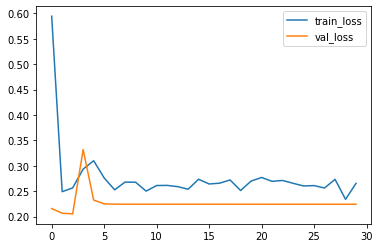

In [15]:
train_losses, val_losses, train_accs, val_accs = train(SGC_base, train_dataloader, val_dataloader, optimizer, scheduler, criterion, num_epoch)
plt.plot(train_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.legend()
plt.show()


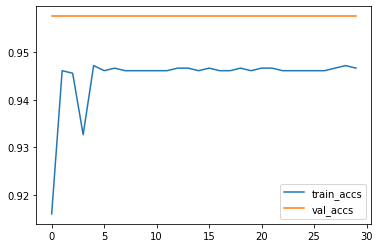

In [16]:
plt.plot(train_accs, label = "train_accs")
plt.plot(val_accs, label = "val_accs")
plt.legend()
plt.show()

In [17]:
test_X = np.load("data/test_feature.npy", allow_pickle = True)
test_A = np.load("data/test_adjacent_matrix.npy", allow_pickle = True)
test_Y = np.load("data/test_label.npy", allow_pickle = True)
test_dataset = MyDataset(test_X, test_A, test_Y, degree)
test_dataloader = DataLoader(test_dataset, batch_size = 32, collate_fn=collate_fn)

In [18]:
test_acc, _ = validate(SGC_base, test_dataloader, criterion)

In [19]:
print(test_acc)

0.6728395061728395
